In [1]:
"""

"""

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import optuna
from category_encoders import OneHotEncoder, MEstimateEncoder, CatBoostEncoder, OrdinalEncoder
from sklearn import set_config
import category_encoders
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.metrics import roc_auc_score, roc_curve, make_scorer, f1_score
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin, clone
from sklearn.preprocessing import FunctionTransformer,StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, BaggingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier, Pool

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
sns.set_theme(style = 'white', palette = 'viridis')
pal = sns.color_palette('viridis')

pd.set_option('display.max_rows', 150)

In [2]:
train = pd.read_csv(r'data/training.csv', index_col='patient_id')
test = pd.read_csv(r'data/test.csv', index_col='patient_id')
sub  = pd.read_csv(r'data/sample_submission.csv')

In [3]:
train.head(3)


patient_race  payer_type patient_state  patient_zip3  patient_age  \
patient_id                                                                     
475714              NaN    MEDICAID            CA           924           84   
349367            White  COMMERCIAL            CA           928           62   
138632            White  COMMERCIAL            TX           760           43   

           patient_gender    bmi breast_cancer_diagnosis_code  \
patient_id                                                      
475714                  F    NaN                       C50919   
349367                  F  28.49                       C50411   
138632                  F  38.09                       C50112   

                                 breast_cancer_diagnosis_desc  \
patient_id                                                      
475714      Malignant neoplasm of unsp site of unspecified...   
349367      Malig neoplm of upper-outer quadrant of right ...   
138632      Malignant neoplasm of central portion of left ...   

           metastatic_cancer_diagnosis_code  ...   disabled    poverty  \
patient_id                                   ...                         
475714                                C7989  ...  12.871429  22.542857   
349367                                 C773  ...   8.957576  10.109091   
138632                                 C773  ...  11.253333   9.663333   

           limited_english commute_time  health_uninsured   veteran  \
patient_id                                                            
475714           10.100000    27.814286         11.200000  3.500000   
349367            8.057576    30.606061          7.018182  4.103030   
138632            3.356667    31.394915         15.066667  7.446667   

                Ozone      PM25        N02  DiagPeriodL90D  
patient_id                                                  
475714      52.237210  8.650555  18.606528               1  
349367      42.301121  8.487175  20.113179               1  
138632      40.108207  7.642753  14.839351               1  

[3 rows x 82 columns]

In [4]:
test.head(3)

patient_race  payer_type patient_state  patient_zip3  patient_age  \
patient_id                                                                     
573710            White    MEDICAID            IN           467           54   
593679              NaN  COMMERCIAL            FL           337           52   
184532         Hispanic    MEDICAID            CA           917           61   

           patient_gender  bmi breast_cancer_diagnosis_code  \
patient_id                                                    
573710                  F  NaN                       C50412   
593679                  F  NaN                       C50912   
184532                  F  NaN                       C50911   

                                 breast_cancer_diagnosis_desc  \
patient_id                                                      
573710      Malig neoplasm of upper-outer quadrant of left...   
593679      Malignant neoplasm of unspecified site of left...   
184532      Malignant neoplasm of unsp site of right femal...   

           metastatic_cancer_diagnosis_code  ...   hispanic   disabled  \
patient_id                                   ...                         
573710                                 C773  ...   3.564516  13.996774   
593679                                 C787  ...  10.261538  16.020513   
184532                                 C773  ...  47.726087   9.895652   

              poverty limited_english  commute_time  health_uninsured  \
patient_id                                                              
573710       7.985484        0.969355     24.955357         10.838710   
593679      13.602564        2.836842     23.952632         10.579487   
184532      10.515217       12.745652     32.530435          7.263043   

             veteran      Ozone      PM25        N02  
patient_id                                            
573710      8.080645  38.724876  7.947165  11.157161  
593679      9.302564  36.918257  7.838973  13.599985  
184532      3.810870  47.310325  9.595719  20.084231  

[3 rows x 81 columns]

In [5]:
desc = pd.DataFrame(index = list(train))
desc['type'] = train.dtypes
desc['count'] = train.count()
desc['nunique'] = train.nunique()
desc['%unique'] = desc['nunique'] /len(train) * 100
desc['null'] = train.isnull().sum()
desc['%null'] = desc['null'] / len(train) * 100
desc = pd.concat([desc,train.describe().T.drop('count',axis=1)],axis=1)
desc.sort_values(by=['type','null']).style.background_gradient(axis=0)

In [7]:
num_cols = train.select_dtypes('number').columns.tolist()
target = 'DiagPeriodL90D'
cat_cols = [c for c in train.columns if c not in num_cols and c != 'DiagPeriodL90D']
num_cols.remove('DiagPeriodL90D')

In [8]:
fig, ax = plt.subplots(12,6, figsize=(25,25), dpi=300) 
ax = ax.flatten()
for i, col in enumerate(num_cols):
    sns.kdeplot(train[col],ax=ax[i],color='b')
    sns.kdeplot(test[col],ax=ax[i],color='g')    
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(None)    
    
for j in range(len(num_cols),len(ax)):
    ax[j].axis('off')
fig.suptitle('Distribution of Feature\nper Dataset\n', fontsize = 24, fontweight = 'bold')
fig.legend(['Train', 'Test'])
plt.tight_layout(h_pad=0.1, w_pad=0.5)
plt.show()

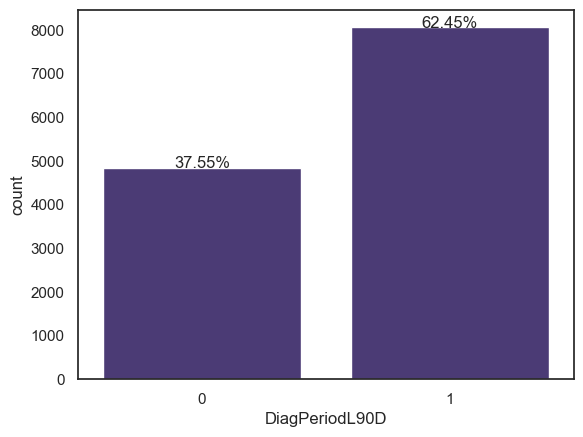

In [9]:
ax = sns.countplot(x=train['DiagPeriodL90D'])

total = len(train['DiagPeriodL90D'])
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height + 0.1,
            '{:.2%}'.format(height / total),
            ha="center")
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_18540\4288001094.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
C:\Users\user\AppData\Local\Temp\ipykernel_18540\4288001094.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
C:\Users\user\AppData\Local\Temp\ipykernel_18540\4288001094.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
C:\Users\user\AppData\Local\Temp\ipykernel_18540\4288001094.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks,

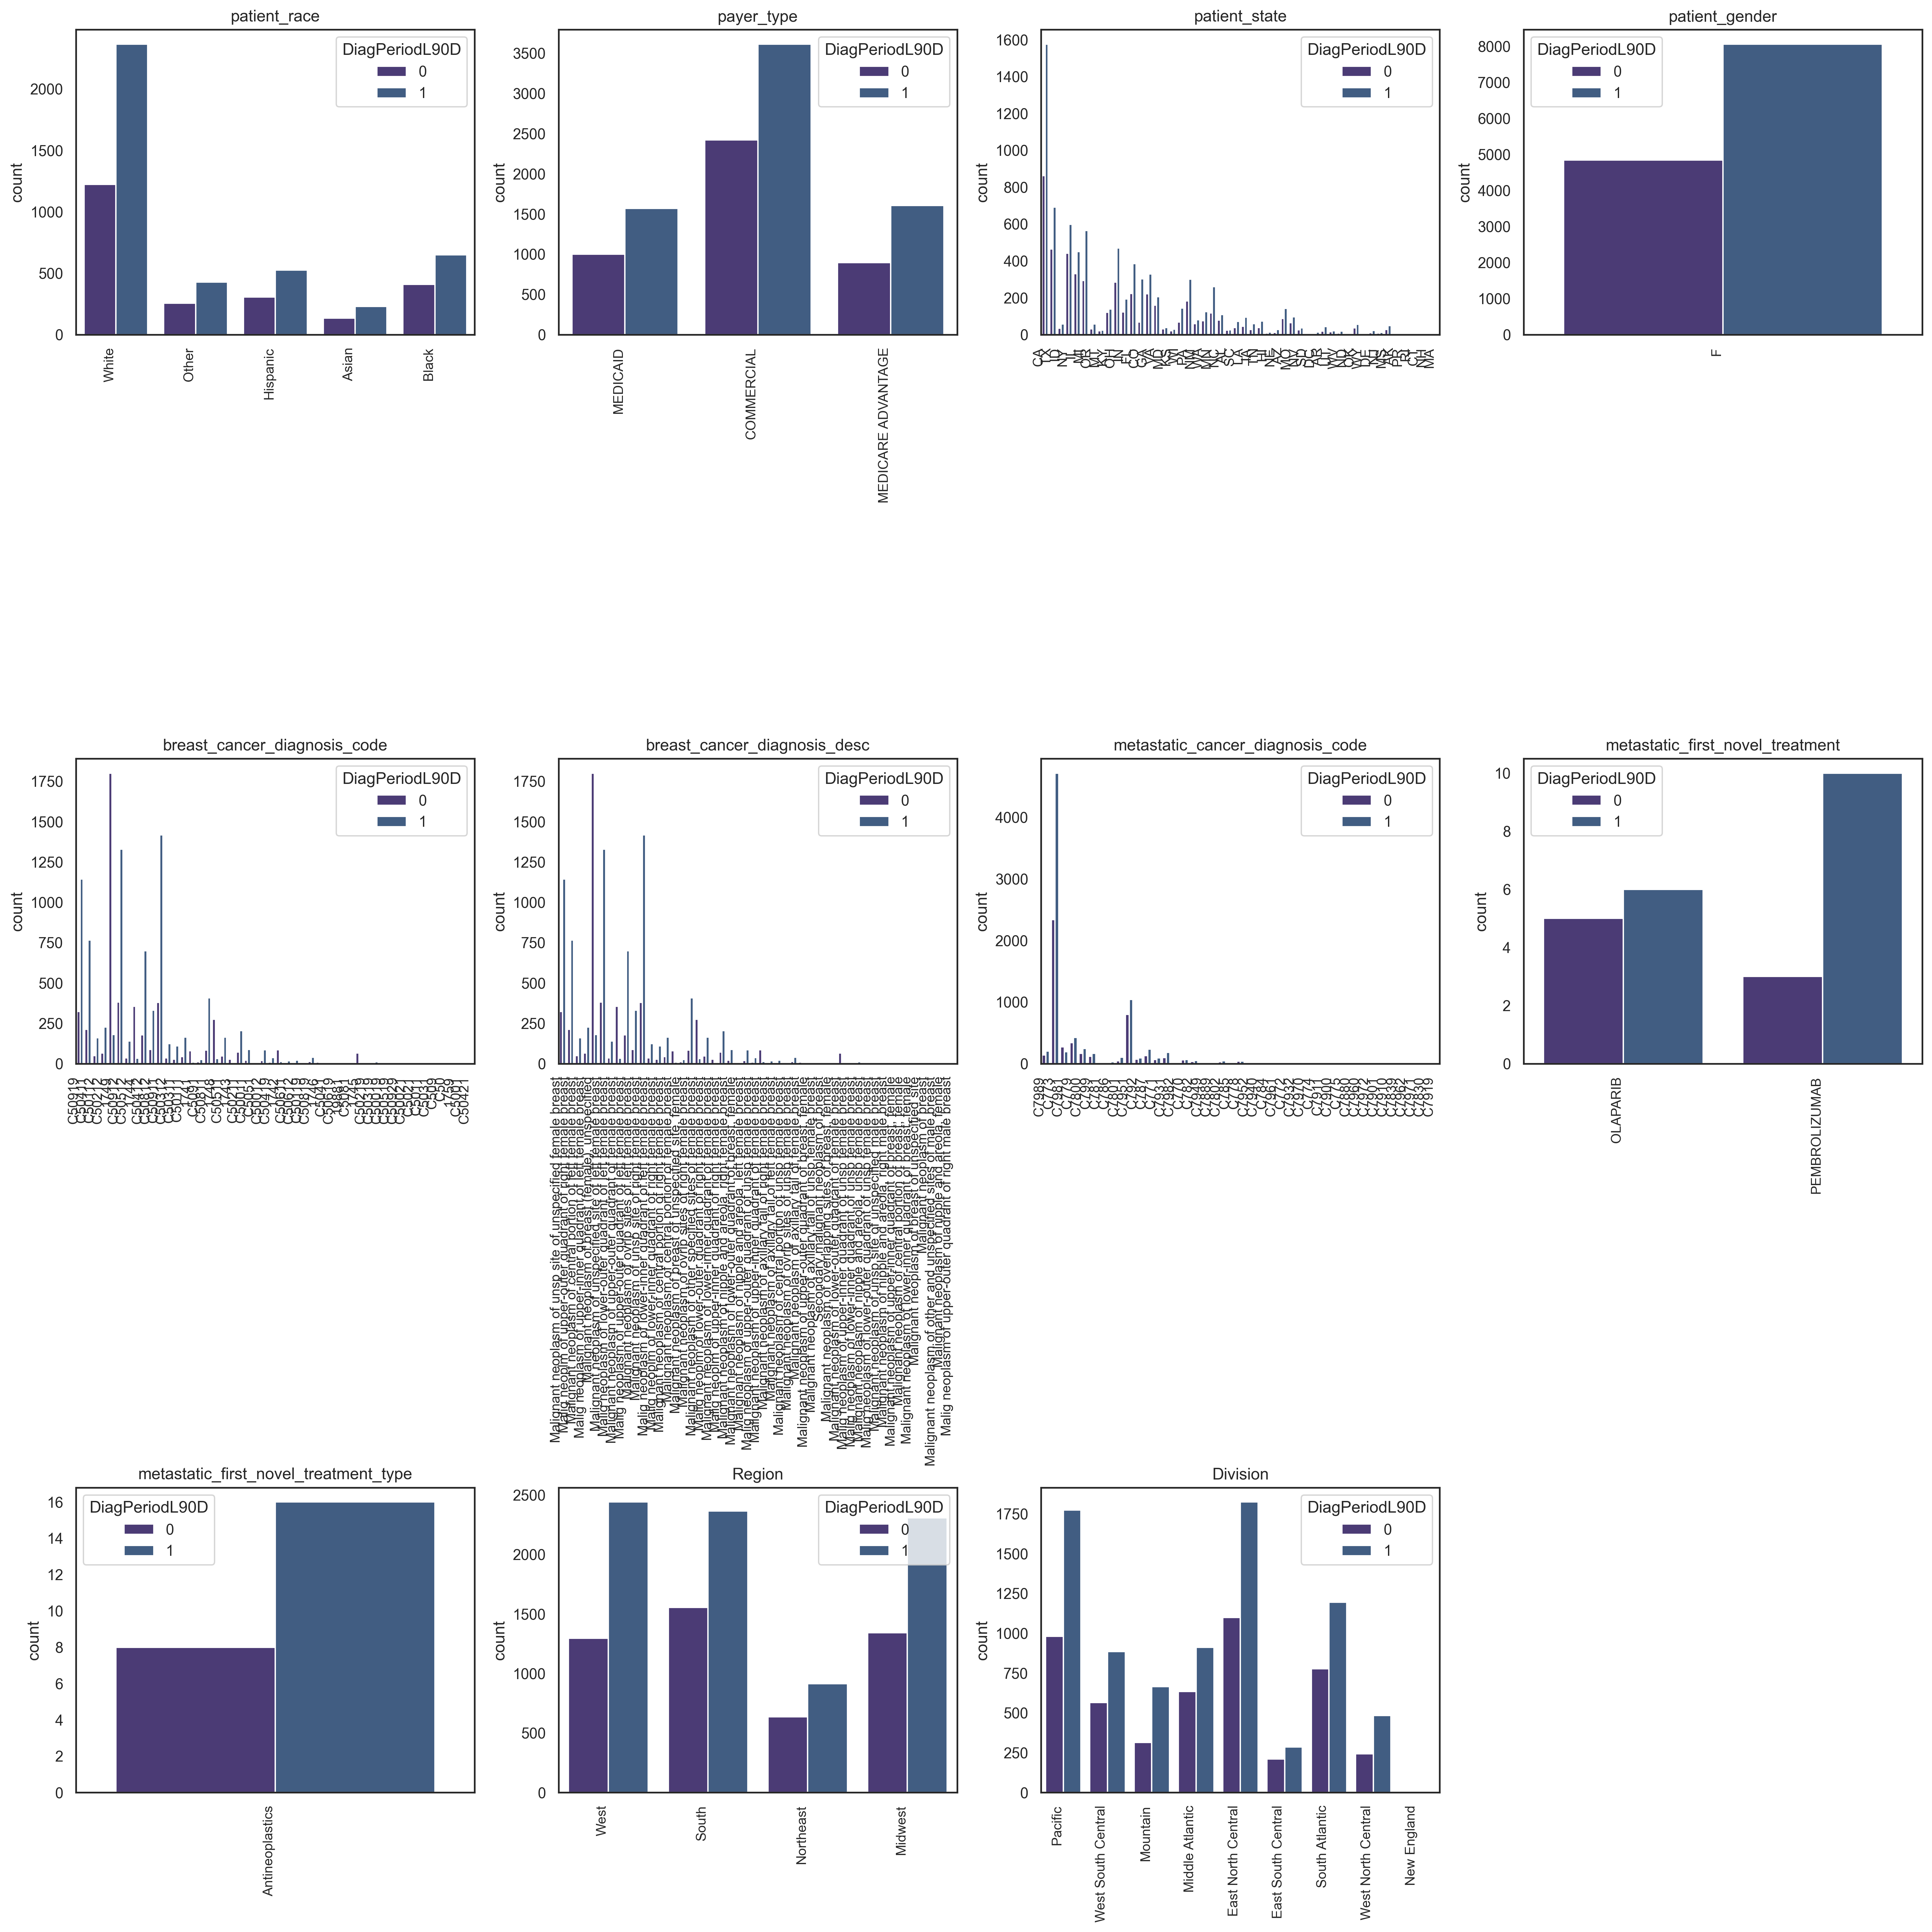

In [10]:
fig, ax = plt.subplots(3,4, figsize=(20,20), dpi=300)
ax = ax.flatten()
plt.subplots_adjust(wspace=0.3, hspace=0.2)
for i, col in enumerate(cat_cols):
    sns.countplot(x=train[col],hue=train[target],ax=ax[i])
    ax[i].set_title(f'{col}')
    ax[i].set_xlabel(None)
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=90, ha='right',fontsize='small')
for j in range(len(cat_cols),len(ax)):
    ax[j].axis('off')
plt.tight_layout(h_pad=0.1)
plt.show()